In [5]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
#Data Preprocessing
#One Time Process
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import random

#Function to calculate trip distance using geopy library.
def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

#Retrieving data from csv.
data = pd.read_csv("data.csv")
data.drop(data.columns[0:8], axis=1, inplace = True)
data = data.rename(columns={"trip_time_in_secs": "trip_time_in_mins"}, inplace=False)
rows = data.index.tolist()
for r in rows:
  data['trip_time_in_mins'][r] = data['trip_time_in_mins'][r] / 60
  
#Number of files and rows required.
customerFiles = 200
customerFilesRows = 52
taxiFiles = 200
taxiFilesRows = 32
safeBufferForCustomerFiles = 5
safeBufferForTaxiFiles = 2

#range of charging station distance.
cs_min = 0.2
cs_max = 1.2
#range of custome waiting time.
cw_min = 1
cw_max = 20
#range of state of charge of batteries for taxis.
soc_min = 0.1
soc_max = 1.0

#Data Modeling
for i in range(customerFiles + taxiFiles):
  if(i < customerFiles):
    df = data[(customerFilesRows + safeBufferForTaxiFiles)*i : (customerFilesRows + safeBufferForTaxiFiles)*(i+1)]
    request_index = df.index.tolist()
    idx = 1
    for index in request_index:
      df.loc[index,'trip_distance'] = round(trip_distance(df['pickup_longitude'][index], df['pickup_latitude'][index], 
                                                        df['dropoff_longitude'][index], df['dropoff_latitude'][index]), 3)
      if df['trip_distance'][index] < 0.5:
        df.drop(index, axis= 0, inplace= True)
        continue
      
      df.loc[index, 'customer_id'] = idx
      idx += 1
      df.loc[index, 'CS_distance'] = round(cs_min + (cs_max - cs_min)*random.random(), 3)
      df.loc[index,'customer_waiting_time_in_mins'] = round(cw_min + (cw_max - cw_min)*random.random(), 1)
    

    df = df.loc[:, ['customer_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                    'trip_distance', 'trip_time_in_mins', 'CS_distance', 'customer_waiting_time_in_mins']]
    df.drop(df.index[500:], inplace=True)
    df.to_csv(f'customer_trip_data_{i+1}_copy.csv', index=False)
    df.drop(df.index[50:], inplace=True)
    df.to_csv(f'customer_trip_data_{i+1}.csv', index=False)
  else:
    df = data[(taxiFilesRows + safeBufferForTaxiFiles)*i : (taxiFilesRows + safeBufferForTaxiFiles)*(i+1)]
    rows = df.index.tolist()
    for r in rows:
      df = df.rename(columns={"pickup_longitude": "taxi_longitude"}, inplace=False)
      df = df.rename(columns={"pickup_latitude": "taxi_latitude"}, inplace=False)

    df.drop('dropoff_longitude', axis= 1, inplace= True)
    df.drop('dropoff_latitude', axis= 1, inplace= True)
    df.drop('trip_time_in_mins', axis= 1, inplace= True)
    df.drop('trip_distance', axis= 1, inplace= True)
    taxi_index = df.index.tolist()
    idx = 1
    for index in taxi_index:
      df.loc[index, 'taxi_id'] = idx
      idx += 1
      df.loc[index, 'soc'] = round(soc_min + (soc_max - soc_min)*random.random(), 2)
    
    df = df.loc[:, ['taxi_id', 'taxi_longitude', 'taxi_latitude', 'soc']]
    df.drop(df.index[300:], inplace=True)
    df.to_csv(f'taxi_data_{i+1-customerFiles}_copy.csv', index=False)
    df.drop(df.index[30:], inplace=True)
    df.to_csv(f'taxi_data_{i+1-customerFiles}.csv', index=False)


C:\Users\siddh\AppData\Local\Temp\ipykernel_20788\3235002786.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trip_time_in_mins'][r] = data['trip_time_in_mins'][r] / 60
C:\Users\siddh\AppData\Local\Temp\ipykernel_20788\3235002786.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'customer_id'] = idx
C:\Users\siddh\AppData\Local\Temp\ipykernel_20788\3235002786.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
#Testing inputs - pickup distance, pickup duration, total trip time etc.
import pandas as pd
from gurobipy import tuplelist
from geopy.distance import great_circle
import math
import itertools
import os
from copy import deepcopy

#Defining Constants
EAV_range = 200.0 #miles
avg_speed_NYC = 13.0 #mph
power_consumption_rate = 0.3 #kWh/mi
need_charging = 0.2 #SOC<20% range
charge_upto = 0.8 #charge upto 80%

max_pickup_time = 30.0 #minutes
max_pickup_dist = max_pickup_time*avg_speed_NYC/60 #miles
max_wait_time = 15.0
charging_power = 50.0 #kW

taxi = pd.read_csv('taxi_data_0.csv')
request = pd.read_csv('customer_trip_data_0.csv')

taxi_index = taxi.index.tolist()
request_index = request.index.tolist()
path = tuplelist(list(itertools.product(taxi_index, request_index)))
taxi = taxi.to_dict(orient="index")
request = request.to_dict(orient="index")

#pickup distance
pickup_distance = pd.DataFrame(index=taxi_index, columns=request_index)
pickup_distance = pickup_distance.to_dict(orient="index")
for each_taxi in taxi_index:
  for each_request in request_index:
    taxi_GPS = (taxi[each_taxi]['taxi_longitude'], taxi[each_taxi]['taxi_latitude'])
    request_GPS = (request[each_request]['pickup_longitude'], request[each_request]['pickup_latitude'])
    pickup_distance[each_taxi][each_request] = 1.4413*great_circle(taxi_GPS, request_GPS).miles + 0.1383 #miles

#pickup time
pickup_time_in_mins = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_time_in_mins[each_taxi][each_request] = int(math.ceil((pickup_distance[each_taxi][each_request]/avg_speed_NYC) * 60))
    
#pickup time + customer_waiting_time(mins)
delay_time_in_mins = deepcopy(pickup_time_in_mins)
for each_taxi in taxi_index:
  for each_request in request_index:
    delay_time_in_mins[each_taxi][each_request] = (pickup_time_in_mins[each_taxi][each_request]
            + request[each_request]['customer_waiting_time_in_mins'])
    
#pickup distance + occupied distance dictionary
pickup_occupied_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance']
            
#pickup distance + occupied distance + charging distance dictionary
pickup_occupied_CS_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_CS_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance'] + request[each_request]['CS_distance']


#customer waiting time weitage.
eta = 1.0
customer_waiting_time = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time_in_mins']

#defining rewards function
reward_function = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]


#printing all parameters to be inputed
print("printing pickup distance")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, pickup_distance[each_taxi][each_request]))
print("\n")
    
print("printing pickup_time_in_mins")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, pickup_time_in_mins[each_taxi][each_request]))  
print("\n")

print("printing delay_time_in_mins")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, delay_time_in_mins[each_taxi][each_request]))
print("\n")

print("printing pickup_occupied_distance")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, pickup_occupied_distance[each_taxi][each_request]))
print("\n")

print("printing pickup_occupied_CS_distance")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, pickup_occupied_CS_distance[each_taxi][each_request]))
print("\n")

print("printing customer_waiting_time")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, customer_waiting_time[each_taxi][each_request]))
print("\n")

print("printing reward_function")
for each_taxi in taxi_index:
  for each_request in request_index:
    print("Taxi {} and customer {} {}".format(each_taxi, each_request, reward_function[each_taxi][each_request]))

printing pickup distance
Taxi 0 and customer 0 5.547343611349608
Taxi 0 and customer 1 3.893885783695418
Taxi 0 and customer 2 21.437816161663907
Taxi 0 and customer 3 0.6072291448844135
Taxi 0 and customer 4 1.168869801019022
Taxi 0 and customer 5 0.8147962509402253
Taxi 0 and customer 6 13.021483976066753
Taxi 0 and customer 7 1.0738353656045938
Taxi 0 and customer 8 5.213849073278436
Taxi 0 and customer 9 1.308385205996032
Taxi 0 and customer 10 5.426014940530678
Taxi 0 and customer 11 1.8866026649042842
Taxi 0 and customer 12 2.7353605962795355
Taxi 0 and customer 13 0.7758774839375295
Taxi 0 and customer 14 0.5560237136578089
Taxi 0 and customer 15 0.9452021323609968
Taxi 0 and customer 16 0.7985452781556286
Taxi 0 and customer 17 3.512942167064851
Taxi 0 and customer 18 4.034349010296177
Taxi 0 and customer 19 13.336211676013084
Taxi 0 and customer 20 4.339183777948428
Taxi 0 and customer 21 1.0182188018602287
Taxi 0 and customer 22 2.454954047919633
Taxi 0 and customer 23 1.4796

In [11]:
#Optimzation Module.
from subprocess import call
import time
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum, tuplelist
from geopy.distance import great_circle
import math
import itertools
from matplotlib import pyplot as plt
from copy import deepcopy

#defining constants
EAV_range = 200.0 #miles
avg_speed_NYC = 13.0 #mph
power_consumption_rate = 0.3 #kWh/mi
need_charging = 0.2 #SOC<20% range
charge_upto = 0.8 #charge upto 80%

max_pickup_time = 30.0 #minutes
max_pickup_dist = max_pickup_time*avg_speed_NYC/60 #miles
max_wait_time = 15.0
charging_power = 50.0 #kW

def clear():
    # check and make call for specific operating system
    _ = call('clear' if os.name == 'posix' else 'cls')

#calculating trip distance using geopy module
def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

#reading data from csv
def readCSV(csvFile):
  data = pd.read_csv(csvFile)
  return data

#convert pd data to dictionary 
def convertToDict(taxi, request):
  taxi_index = taxi.index.tolist()
  request_index = request.index.tolist()
  path = tuplelist(list(itertools.product(taxi_index, request_index)))
  taxi = taxi.to_dict(orient="index")
  request = request.to_dict(orient="index")
  return path, taxi, request, taxi_index, request_index

#Get request based inputs
def getProvidedInputs(taxi, request, taxi_index, request_index):
  #pickup distance
  pickup_distance = pd.DataFrame(index=taxi_index, columns=request_index)
  pickup_distance = pickup_distance.to_dict(orient="index")
  for each_taxi in taxi_index:
    for each_request in request_index:
      taxi_GPS = (taxi[each_taxi]['taxi_longitude'], taxi[each_taxi]['taxi_latitude'])
      request_GPS = (request[each_request]['pickup_longitude'], request[each_request]['pickup_latitude'])
      pickup_distance[each_taxi][each_request] = 1.4413*great_circle(taxi_GPS, request_GPS).miles + 0.1383 #miles

  #pickup time
  pickup_time_in_mins = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_time_in_mins[each_taxi][each_request] = int(math.ceil((pickup_distance[each_taxi][each_request]/avg_speed_NYC) * 60))
      
  #pickup time + customer_waiting_time(mins)
  delay_time_in_mins = deepcopy(pickup_time_in_mins)
  for each_taxi in taxi_index:
    for each_request in request_index:
      delay_time_in_mins[each_taxi][each_request] = (pickup_time_in_mins[each_taxi][each_request]
                                                          + request[each_request]['customer_waiting_time_in_mins'])
      
  #pickup distance + occupied distance dictionary
  pickup_occupied_distance = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_occupied_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance']
              
  #pickup distance + occupied distance + charging distance dictionary
  pickup_occupied_CS_distance = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_occupied_CS_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance'] + request[each_request]['CS_distance']

  return pickup_distance, pickup_time_in_mins, delay_time_in_mins, pickup_occupied_distance, pickup_occupied_CS_distance


#customer waiting time weitage
def customerWaitingTime(request, pickup_distance, eta = 1.0):
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time_in_mins']
  return customer_waiting_time;


#reward function
def rewardFunction(taxi, request, taxi_index, request_index, pickup_time_in_mins, customer_waiting_time):
  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]
  return reward_function

#defining model optimization
def optimize(taxi, request, taxi_index, request_index, pickup_occupied_CS_distance, pickup_time_in_mins, customer_waiting_time, reward_function):
  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)
      
  #solve
  model.optimize()
  return model


#print solution
def printModelSolution(model):
  for v in model.getVars():
    if v.x == 1.0:
      print(v.varName, v.x)
  print('Obj:', model.objVal) 


#defining model optimization
def realTimeOptimization(taxi, request, taxi_index, request_index, pickup_occupied_CS_distance, pickup_time_in_mins, customer_waiting_time, reward_function):
  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max
      if(taxi[each_taxi]['taxi_availability'] < time.time()):
        model.addConstr(x[each_taxi, each_request]==0)

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)
      
  #solve
  model.optimize()
  return model

In [12]:
#Optimized Solutions
taxi = readCSV('taxi_data_0.csv')
request = readCSV('customer_trip_data_0.csv')

path, taxi, request, taxi_index, request_index = convertToDict(taxi, request)

pickup_distance, pickup_time_in_mins, delay_time_in_mins, pickup_occupied_distance, pickup_occupied_CS_distance = getProvidedInputs(taxi, request, taxi_index, request_index)

#customer waiting time
eta = 1.0
customer_waiting_time = customerWaitingTime(request, pickup_distance ,eta)

#Reward Function
reward_function = rewardFunction(taxi, request, taxi_index, request_index, pickup_time_in_mins, customer_waiting_time)

#Optmized Model
model = optimize(taxi, request, taxi_index, request_index, pickup_occupied_CS_distance, pickup_time_in_mins, customer_waiting_time, reward_function)

#print solution
printModelSolution(model)

Restricted license - for non-production use only - expires 2024-10-28
x[0,3] 1.0
x[1,46] 1.0
x[2,7] 1.0
x[4,1] 1.0
x[5,30] 1.0
x[6,43] 1.0
x[7,11] 1.0
x[8,36] 1.0
x[9,34] 1.0
x[10,35] 1.0
x[11,16] 1.0
x[12,38] 1.0
x[13,19] 1.0
x[14,24] 1.0
x[15,10] 1.0
x[16,47] 1.0
x[17,40] 1.0
x[18,4] 1.0
x[19,23] 1.0
x[20,29] 1.0
x[21,13] 1.0
x[22,17] 1.0
x[23,8] 1.0
x[24,28] 1.0
x[25,27] 1.0
x[26,0] 1.0
x[27,9] 1.0
x[28,32] 1.0
x[29,49] 1.0
Obj: 1010.4000000000001


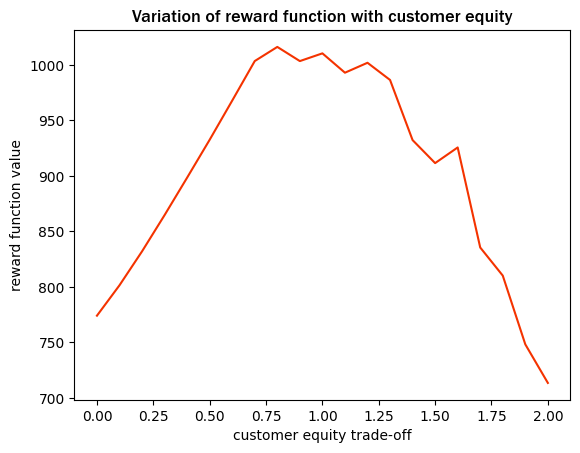

In [13]:
#Analysis - reward fxn vs eta
import matplotlib.pyplot as plt

eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
obj_function_val = np.array([])

for eta in eta_list:
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time_in_mins'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)
  obj_function_val = np.append(obj_function_val, model.objVal)

# plt.plot(eta_list, obj_function_val)
# plt.xlabel("customer equity trade-off")
# plt.ylabel("reward function value")
# plt.show()

fig, ax = plt.subplots()
ax.set_title("Variation of reward function with customer equity", fontname = 'Franklin Gothic Medium', fontsize = 13)
ax.set_xlabel("customer equity trade-off", fontname = 'Sans', fontsize = 10)
ax.set_ylabel("reward function value", fontname = 'Sans', fontsize = 10)
ax.plot(eta_list, obj_function_val, "#F43300")

plt.show()

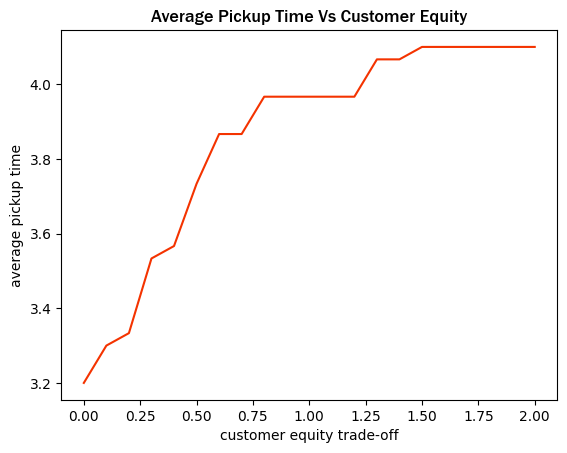

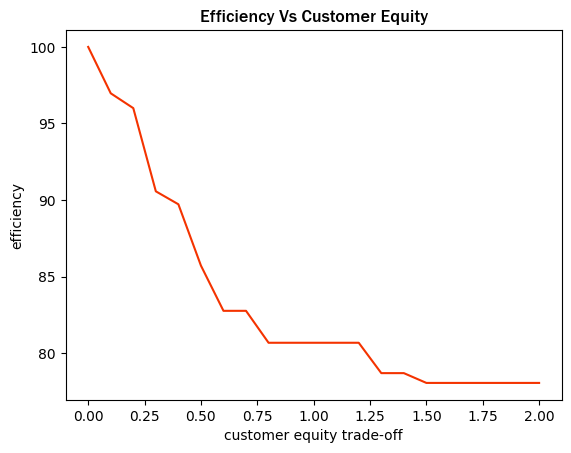

In [14]:
#Analysis - eta vs efficiency
eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
efficiency = np.array([])
pickup_time = np.array([])

for eta in eta_list:
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time_in_mins'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      # if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
      #   model.addConstr(x[each_taxi, each_request]==0)  #if included then at higher eta values all customer waiting time will be more than maximum

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)

  total_pickup_time = 0.0
  for v in model.getVars():
    if v.x == 1.0:
      str = v.varName
      total_pickup_time += pickup_time_in_mins[int((str.split(',')[0]).split('[')[1])][int((str.split(',')[1]).split(']')[0])]
  
  avg_pickup_time = 0.0
  avg_pickup_time = (total_pickup_time)/(len(taxi_index))

  pickup_time = np.append(pickup_time, avg_pickup_time)

plt.plot(eta_list, pickup_time, "#F43300")
plt.title("Average Pickup Time Vs Customer Equity", fontname = 'Franklin Gothic Medium', fontsize = 13)
plt.xlabel("customer equity trade-off", fontname = 'Sans', fontsize = 10)
plt.ylabel("average pickup time", fontname = 'Sans', fontsize = 10)
plt.show()

efficiency = (1/pickup_time)
mutliplicationFactor = 100/efficiency[0]
efficiency *= mutliplicationFactor
plt.plot(eta_list, efficiency, "#F43300")
plt.title("Efficiency Vs Customer Equity", fontname = 'Franklin Gothic Medium', fontsize = 13)
plt.xlabel("customer equity trade-off", fontname = 'Sans', fontsize = 10)
plt.ylabel("efficiency", fontname = 'Sans', fontsize = 10)
plt.show()

C:\Users\siddh\AppData\Local\Temp\ipykernel_20788\1681587364.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return total / (len(x)**2 * np.mean(x))


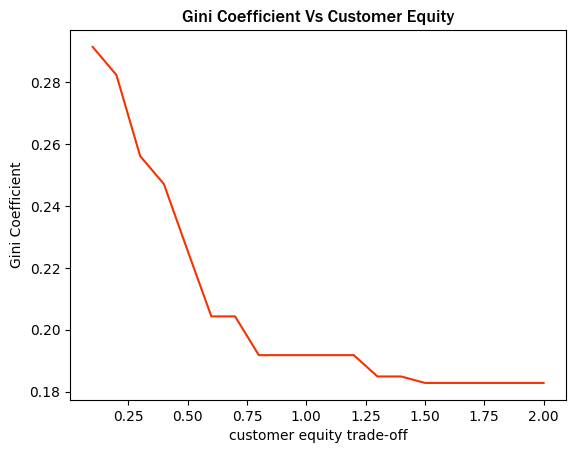

In [15]:
#Analysis - gini coefficient(Lorenz Curve)
eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
gini_coefficient = np.array([])

#reference: https://www.statology.org/gini-coefficient-python/
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

for eta in eta_list:
  customer_waiting_time_distribution = np.array([])
  
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time_in_mins'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      # if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
      #   model.addConstr(x[each_taxi, each_request]==0)

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)

  total_pickup_time = 0.0
  for v in model.getVars():
    if v.x == 1.0:
      str = v.varName
      customer_waiting_time_distribution = np.append(customer_waiting_time_distribution, customer_waiting_time[int((str.split(',')[0]).split('[')[1])][int((str.split(',')[1]).split(']')[0])])

  gini_coefficient = np.append(gini_coefficient, gini(customer_waiting_time_distribution))

plt.plot(eta_list, gini_coefficient, "#F43300")
plt.title("Gini Coefficient Vs Customer Equity", fontname = 'Franklin Gothic Medium', fontsize = 13)
plt.xlabel("customer equity trade-off", fontname = 'Sans', fontsize = 10)
plt.ylabel("Gini Coefficient", fontname = 'Sans', fontsize = 10)
plt.show()

[0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.7, 0.9, 0.7, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.9, 0.8, 1.4, 0.9, 0.7, 0.7, 0.9, 0.8, 0.8, 1.0, 0.8, 0.8, 0.8, 0.7, 1.0, 0.8, 0.8, 1.1, 0.8, 0.7, 0.9, 0.8, 0.8, 0.8, 0.8, 0.9, 0.8, 0.9, 0.9, 0.7, 0.7, 0.7, 0.8, 0.9, 0.8, 0.8, 0.9, 0.8, 0.7, 0.7, 0.9, 0.7, 0.8, 0.8, 0.8, 0.9, 0.8, 0.8, 0.9, 1.0, 0.8, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 0.7, 1.0, 1.0, 0.9, 0.9, 0.8, 1.0, 0.8, 0.8, 0.7, 0.8, 0.7, 0.8, 1.3, 0.7, 0.7, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 1.2, 0.7, 0.8, 0.7, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 1.0, 1.0, 0.7, 0.8, 0.7, 0.8, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.8, 1.0, 0.7, 0.7, 0.8, 0.9, 0.8, 0.7, 1.0, 0.7, 0.9, 0.9, 0.8, 0.9, 0.8, 0.8, 1.0, 0.9, 1.0, 0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 1.1, 0.8, 0.9, 0.7, 1.1, 0.8, 0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 1.0, 1.0, 0.8, 0.7, 0.8, 0.8, 0.7, 0.8, 0.9, 0.7, 0.7, 0.8, 0.8, 1.0, 0.8, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.9, 0.7, 0.8]

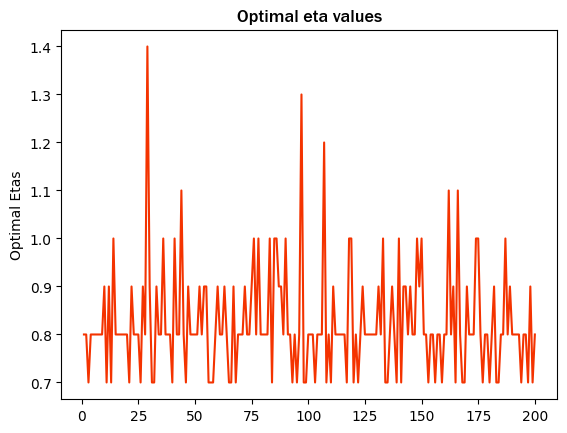

In [16]:
#Analysis - optimal eta with different datasets (to find the best eta)
import numpy
import matplotlib.pyplot as plt


allOptimalEtas = []
for idx in range(1, customerFiles + 1):
    eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
    optimalEta = 1.0
    maxObjVal = 0.0
    for eta in eta_list:
        taxi = readCSV(f'taxi_data_{idx}.csv')
        request = readCSV(f'customer_trip_data_{idx}.csv')
        path, taxi, request, taxi_index, request_index = convertToDict(taxi, request)
        pickup_distance, pickup_time_in_mins, delay_time_in_mins, pickup_occupied_distance, pickup_occupied_CS_distance = getProvidedInputs(taxi, request, taxi_index, request_index)
        customer_waiting_time = customerWaitingTime(request, pickup_distance ,eta)

        reward_function = rewardFunction(taxi, request, taxi_index, request_index, pickup_time_in_mins, customer_waiting_time)
        model = optimize(taxi, request, taxi_index, request_index, pickup_occupied_CS_distance, pickup_time_in_mins, customer_waiting_time, reward_function)
        if model.objVal > maxObjVal:
            maxObjVal = model.objVal
            optimalEta = eta
    allOptimalEtas.append(optimalEta)

print(allOptimalEtas)
xCord = (np.arange(1, customerFiles + 1, 1).tolist())
plt.plot(xCord, allOptimalEtas, "#F43300")
plt.title("Optimal eta values",  fontname = 'Franklin Gothic Medium', fontsize = 13)
plt.ylabel("Optimal Etas", fontname = 'Sans', fontsize = 10)
optimalEta = numpy.average(allOptimalEtas)
print(optimalEta)

In [17]:
#Real Time Optimization
from subprocess import call
import time
from datetime import datetime

delay = 3 
taxiCSV = 'taxi_data_0.csv'
taxiDf = readCSV(taxiCSV)   
taxiDf['taxi_availability'] = 0

for idx in range(1, customerFiles + 1):     #don't touch the _0 config file. It's main file.
    print(f'Time Of Request= {datetime.now().time()}')
    requestCSV = f'customer_trip_data_{idx}.csv'
    requestDf = readCSV(requestCSV)
    
    path, taxi, request, taxi_index, request_index = convertToDict(taxiDf, requestDf)
    pickup_distance, pickup_time_in_mins, delay_time_in_mins, pickup_occupied_distance, pickup_occupied_CS_distance = getProvidedInputs(taxi, request, taxi_index, request_index)

    eta = 1.0
    customer_waiting_time = customerWaitingTime(request, pickup_distance ,eta)
    reward_function = rewardFunction(taxi, request, taxi_index, request_index, pickup_time_in_mins, customer_waiting_time)
    model = realTimeOptimization(taxi, request, taxi_index, request_index, pickup_occupied_CS_distance, pickup_time_in_mins, customer_waiting_time, reward_function)

    printModelSolution(model)
    
    for v in model.getVars():
        str = v.varName
        taxiUsed = int((str.split(',')[0]).split('[')[1])
        requestServed = int((str.split(',')[1]).split(']')[0])
        if v.x == 1.0:
            taxiDf['taxi_longitude'][taxiUsed] = requestDf['dropoff_longitude'][requestServed]
            taxiDf['taxi_latitude'][taxiUsed] = requestDf['dropoff_latitude'][requestServed]
            if(taxiDf['soc'][taxiUsed] - (pickup_occupied_distance[taxiUsed][requestServed]/ EAV_range) < soc_min):
                taxiDf['soc'][taxiUsed] = taxiDf['soc'][taxiUsed] - (pickup_occupied_CS_distance[taxiUsed][requestServed]/ EAV_range)
                taxiDf['taxi_availability'][taxiUsed] = time.time() + (pickup_occupied_distance[taxiUsed][requestServed] / avg_speed_NYC)
            else:
                taxiDf['soc'][taxiUsed] = taxiDf['soc'][taxiUsed] - (pickup_occupied_distance[taxiUsed][requestServed]/ EAV_range)
                taxiDf['taxi_availability'][taxiUsed] = time.time() + 30*60
                taxiDf['soc'][taxiUsed] = 1.0
        else:
            if taxiDf['taxi_availability'][taxiUsed] <= time.time():
                taxiDf['taxi_availability'][taxiUsed] = time.time() + 30*60
                taxiDf['soc'][taxiUsed] = 1.0

    taxiDf.to_csv(taxiCSV, index = False)
    time.sleep(delay)  #taking next requests after a delay of {delay}.

Time Of Request= 00:41:49.860182


GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8 ])
y = np.array([ 20, 30, 5, 12, 39, 48, 50, 3 ])
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Curve plotted using the given points")
plt.xlabel("X")
plt.ylabel("Y")

plt.axhline(y=np.nanmean(y))
plt.show()

In [ ]:
str = "x[0,3]"
taxi = int((str.split(',')[0]).split('[')[1])
print(taxi)
request = int((str.split(',')[1]).split(']')[0])
print(request)

print(type(taxi))
print(type(request))
print(taxi * request)

# total_pickup_time += pickup_time_in_mins[int((v.varName.split(',')[0]).split('[')[1]), int((v.varName.split(',')[1]).split(']')[0])]  

In [ ]:
import time
import datetime

print(time.time())


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.array([1, 3, 5, 3, 1])
y = np.array([2, 1, 3, 1, 2])
line, = ax.plot(x, y)

ymax = max(y)
xpos = np.where(y == ymax)
xmax = x[xpos]

ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax + 5), arrowprops=dict(facecolor='black'),)

plt.show()